In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tenfem
from scipy.integrate import quad

In [2]:
tri_mesh = tenfem.mesh.examples.square(2, 2)
tri_element = tenfem.reference_elements.TriangleElement(degree=1)
# tri_element.get_quadrature_nodes(tri_mesh)

In [3]:
n_nodes = 5
a, b = 0., 2.
nodes = np.linspace(a, b, n_nodes)[:, np.newaxis]
elements = np.column_stack((np.arange(0, n_nodes-1), np.arange(1, n_nodes)))
boundary_elements = [[0, ], [n_nodes-1, ]]

mesh = tenfem.mesh.IntervalMesh(nodes, elements, boundary_elements)

# Some words of caution

We have taken our reference element to be $[0, 1]$ to easily define the shape functions,
but the Gauss quadrature nodes are on the interval therefore over each element
we must adjust be the scaling factor 

$$
\frac{(b_i - a_i)}{2}
$$

this is automatically taken care of in the `quadrature` method.

In [4]:
#ref_element = tenfem.reference_elements.IntervalElement(# .get_quadrature_nodes(mesh)
ref_element = tenfem.reference_elements.IntervalElement(degree=1, dtype=tf.float64)
quad_nodes, quad_weights = ref_element.get_quadrature_nodes_and_weights()

In [5]:
def f(x):
    return x[..., 0]

def quadrature(self, f, mesh):
    """ Perform quadrature of a function over the mesh. 
    
    Args:
        f: A scalar callable, when evaluated at a mesh node of shape 
          `[..., spatial_dim]` it should return a `Tensor` of shape
          `[..., ]` with the same `dtype` as `mesh.
    
    Returns
        integral: A quadrature approximation to the integral of
          f over the mesh.
    """
    mesh_quad_nodes, quad_weights = self.get_mesh_quadrature_nodes(mesh)

    f_at_nodes = f(mesh_quad_nodes)
    volumes = self.get_element_volumes(mesh)
    return 0.5 * tf.reduce_sum(f_at_nodes 
                               * quad_weights
                               * volumes[..., tf.newaxis], axis=[-1, -2])
    

I, err = quad(lambda x: x, a, b)
print(I)
print(quadrature(ref_element, f, mesh))
print(ref_element.quadrature(f, mesh))

2.0
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)


In [6]:
rr = np.linspace(0., 1., 4)

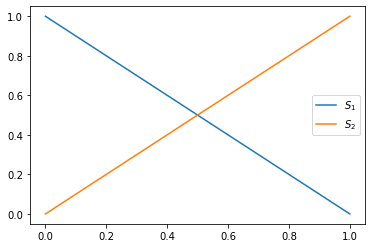

In [7]:
xx = np.linspace(0., 1.)
s, ds = ref_element.shape_function(xx)

fig, ax = plt.subplots()
ax.plot(xx, s[..., 0], label='$S_1$')
ax.plot(xx, s[..., 1], label='$S_2$')
ax.legend()
plt.show()

In [8]:
def foo():
    wts, quad_nodes = element.get_quadrature_nodes_and_weights()
    _, pf_shape_fn_grad, jac_det = element.isomap(element_nodes, quad_nodes)
    pass

In [9]:
self = ref_element

r, w = self.get_quadrature_nodes_and_weights()

shape_fn_vals, shape_fn_grad = self.shape_function(r)



`shape_fn_grad` is a tensor of shape `[1, n, element_dim]`, in the case of linear elements it is
we have

```
shape_fn_grad[0, :, 0] = -tf.ones(n)
shape_fn_grad[0, :, 1] = tf.ones(n)
```

In [10]:
element_nodes = tf.gather(mesh.nodes, mesh.elements)

wts, quad_nodes = ref_element.get_quadrature_nodes_and_weights()

_, pf_shape_fn_grad, jac_det = ref_element.isomap(element_nodes, quad_nodes)

wxarea = jac_det * wts / 2

pf_shape_fn_grad.shape

TensorShape([1, 4, 2, 2])

In [22]:
diff_coeff = tf.ones([mesh.n_elements, 2], dtype=ref_element.dtype)

local_stiffness_mat = tenfem.fem.assemble_local_stiffness_matrix(diff_coeff, mesh, ref_element)
global_stiffness_mat = tenfem.fem.scatter_matrix_to_global(
    local_stiffness_mat[tf.newaxis, ...],
    mesh.elements[None, ...],
    mesh.n_nodes)

h = np.diff(mesh.nodes[:, 0])
print(1/ h)

print(local_stiffness_mat)
print(global_stiffness_mat[0])

[2. 2. 2. 2.]
tf.Tensor(
[[[ 2. -2.]
  [-2.  2.]]

 [[ 2. -2.]
  [-2.  2.]]

 [[ 2. -2.]
  [-2.  2.]]

 [[ 2. -2.]
  [-2.  2.]]], shape=(4, 2, 2), dtype=float64)
tf.Tensor(
[[ 2. -2.  0.  0.  0.]
 [-2.  4. -2.  0.  0.]
 [ 0. -2.  4. -2.  0.]
 [ 0.  0. -2.  4. -2.]
 [ 0.  0.  0. -2.  2.]], shape=(5, 5), dtype=float64)


In [26]:
np.eye(5) - np.eye(5, k=-1) - np.eye(5, k=1)

array([[ 1., -1.,  0.,  0.,  0.],
       [-1.,  1., -1.,  0.,  0.],
       [ 0., -1.,  1., -1.,  0.],
       [ 0.,  0., -1.,  1., -1.],
       [ 0.,  0.,  0., -1.,  1.]])

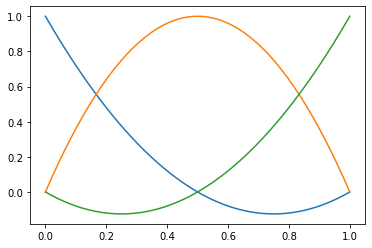

In [12]:
s1 = lambda r: (1-3*r + 2*r**2)
s2 = lambda r: 4*(r-r**2)
s3 = lambda r: -r + 2*r**2

rr = np.linspace(0., 1.)

fig, ax = plt.subplots()
ax.plot(rr, s1(rr))
ax.plot(rr, s2(rr))
ax.plot(rr, s3(rr))
plt.show()